In [1]:
import cv2, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import tensorflow as tf
import time

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import losses, regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import  Callback, CSVLogger,  History, ModelCheckpoint, EarlyStopping
from params import preprocess, load_data, loss_histroy, data_dir, out_dir, model_dir
from custom_model import nvidia_model, custom_model, fine_tuning

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

%matplotlib inline

Using TensorFlow backend.


In [2]:
epoch01_steering = pd.read_csv('./epochs/epoch01_steering.csv')
epoch01_steering.head()

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0


### 读入数据

In [3]:
epoch_dir = os.path.abspath('./epochs')
output_dir = os.path.abspath('./output')
model_dir = os.path.abspath('./models')

In [4]:
epoch_csv = glob.glob(os.path.join(epoch_dir, "*steering.csv"))
# print(epoch_csv)

In [6]:
# csv列合并
steering_csv = pd.concat((pd.read_csv(f) for f in epoch_csv))
steering_csv.shape

(27000, 4)

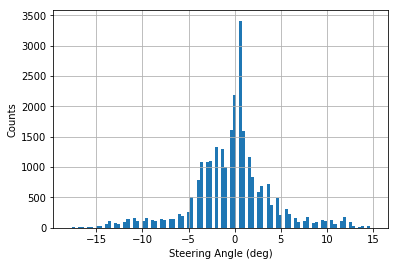

In [7]:
wheel = steering_csv['wheel']
plt.figure
plt.hist(wheel,100);
plt.xlabel('Steering Angle (deg)')
plt.ylabel('Counts')
plt.grid(True)

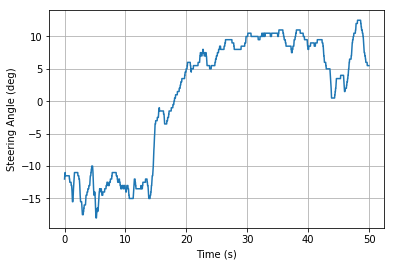

In [8]:
plt.figure;
plt.plot(np.arange( 0, 50, 1/30),wheel[:1500]);
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (deg)')
plt.grid(True)

In [9]:
cap = cv2.VideoCapture("epochs/epoch05_front.mkv")
# cap = cv2.VideoCapture(os.path.join(epoch_dir, "epoch02_front.mkv"))
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = int(cap.get(cv2.CAP_PROP_FPS))

print (length,width,height,fps)

2702 1280 720 30


### 预处理

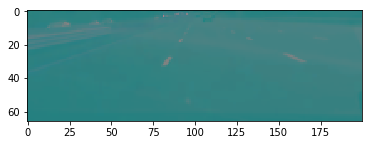

In [11]:
# epochs 1-9 as train data
imgs_data_yuv, wheels_data_yuv = load_data('train', 'YUV', flip=True)
# imgs_data, wheels_data = load_data('train', 'YUV', flip=False)
plt.imshow(imgs_data_yuv[1])

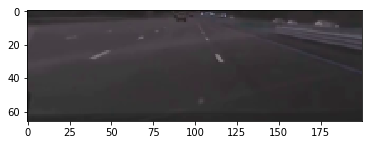

In [12]:
# rgb
imgs_data_normal, wheels_data_normal = load_data('train', flip=True)
plt.imshow(imgs_data_normal[1])

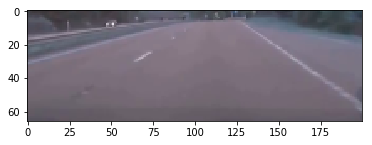

In [13]:
# epoch 10 as test data
imgs_test_normal, wheels_test_normal = load_data('test')
plt.imshow(imgs_test_normal[1])

In [14]:
imgs_data_normal.shape, wheels_data_normal.shape

((48600, 66, 200, 3), (48600, 1))

In [4]:
dumps_dir = os.path.abspath('./dumps')

imgs_train_yuv_file =os.path.join(dumps_dir, "data_imgs_yuv_train.p")
wheels_train_yuv_file =os.path.join(dumps_dir, "data_wheels_yuv_train.p")
imgs_normal_train_file =os.path.join(dumps_dir, "data_imgs_normal_train.p")
wheels_normal_train_file =os.path.join(dumps_dir, "data_wheels_normal_train.p")

imgs_test_normal_file =os.path.join(dumps_dir, "data_imgs_test.p")
wheels_test_normal_file =os.path.join(dumps_dir, "data_wheels_test.p")

In [16]:
# Save train data
pickle.dump(imgs_data_yuv, open(imgs_train_yuv_file, 'wb'))
pickle.dump(wheels_data_yuv, open(wheels_train_yuv_file, 'wb'))

pickle.dump(imgs_data_normal, open(imgs_normal_train_file, 'wb'))
pickle.dump(wheels_data_normal, open(wheels_normal_train_file, 'wb'))

# Save test data into a pickle file.
pickle.dump(imgs_test_normal, open(imgs_test_normal_file, 'wb'))
pickle.dump(wheels_test_normal, open(wheels_test_normal_file, 'wb'))

In [5]:
# open the pickle file
imgs_data_yuv = pickle.load(open(imgs_train_yuv_file, 'rb'))
wheels_data_yuv = pickle.load(open(wheels_train_yuv_file, 'rb'))

imgs_data_normal = pickle.load(open(imgs_normal_train_file, 'rb'))
wheels_data_normal = pickle.load(open(wheels_normal_train_file, 'rb'))

# test
imgs_test = pickle.load(open(imgs_test_normal_file, 'rb'))
wheels_test = pickle.load(open(wheels_test_normal_file, 'rb'))

In [6]:
print(imgs_data_yuv.shape, wheels_data_yuv.shape)
print(imgs_test.shape, wheels_test.shape)
print(imgs_data_normal.shape, wheels_data_normal.shape)

(24300, 66, 200, 3) (24300, 1)
(2700, 66, 200, 3) (2700, 1)
(48600, 66, 200, 3) (48600, 1)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(imgs_data_normal, wheels_data_normal, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape, '\nX_val shape:',X_val.shape)
print('y_train shape:',y_train.shape, '\ny_val shape:',y_val.shape)

X_train shape: (38880, 66, 200, 3) 
X_val shape: (9720, 66, 200, 3)
y_train shape: (38880, 1) 
y_val shape: (9720, 1)


### 基准模型 NVIDIA MODEL

In [22]:
# # NVIDIA model
# def nvidia_model(img_height, img_width, img_channels):
#     model = Sequential()
#     model.add(Lambda(lambda x: x/255.-0.5, input_shape=(img_height, img_width, img_channels)))
#     # model.add(Lambda(lambda x: x/255., input_shape=(img_height, img_width, img_channels)))
#     # Cov layers
#     model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid', activation='relu'))
#     model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid', activation='relu'))
#     model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid', activation='relu'))
#     model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu'))
#     model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu'))
#     # Fullyconnected layer
#     model.add(Flatten())
#     model.add(Dense(1164, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mse', optimizer='adadelta', metrics=['mse'])
#     # model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
#     return model

In [23]:
img_height = 66
img_width = 200
img_channels = 3
epochs = 10
batch_size=128

# Train the model with ordered data 
base_model = nvidia_model(img_height, img_width, img_channels)
base_history = base_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, 
                              validation_data=(X_val, y_val))

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/15
38880/38880 [==============================] - 22s 555us/step - loss: 21.0616 - mean_squared_error: 21.0616 - val_loss: 21.4767 - val_mean_squared_error: 21.4767
Epoch 2/15
38880/38880 [==============================] - 21s 547us/step - loss: 15.4390 - mean_squared_error: 15.4390 - val_loss: 6.4903 - val_mean_squared_error: 6.4903
Epoch 3/15
38880/38880 [==============================] - 21s 547us/step - loss: 4.2842 - mean_squared_error: 4.2842 - val_loss: 2.3688 - val_mean_squared_error: 2.3688
Epoch 4/15
38880/38880 [==============================] - 21s 547us/step - loss: 1.8738 - mean_squared_error: 1.8738 - val_loss: 1.5708 - val_mean_squared_error: 1.5708
Epoch 5/15
38880/38880 [==============================] - 21s 546us/step - loss: 1.2049 - mean_squared_error: 1.2049 - val_loss: 1.1712 - val_mean_squared_error: 1.1712
Epoch 6/15
38880/38880 [==============================] - 21s 551us/step - loss: 0.8800 - mean_squar

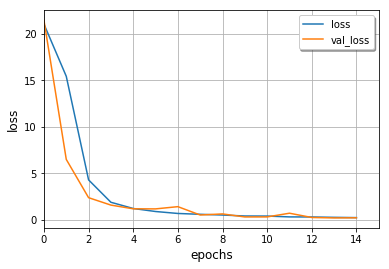

In [39]:
loss_histroy(base_history, epochs)

In [41]:
# save
weights_file = './models/nvidia-model.h5'
model_file = './models/nvidia-model.json'
base_model.save_weights(weights_file)
with open(model_file, 'w') as f:
    f.write(base_model.to_json())

In [43]:
# shuffle data
base_model = nvidia_model(img_height, img_width, img_channels)
base_shuffle_history = base_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, 
                                      validation_data=(X_val, y_val), shuffle=True)

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))


Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 22s 560us/step - loss: 16.2964 - mean_squared_error: 16.2964 - val_loss: 7.5537 - val_mean_squared_error: 7.5537
Epoch 2/10
38880/38880 [==============================] - 21s 547us/step - loss: 4.4973 - mean_squared_error: 4.4973 - val_loss: 2.3014 - val_mean_squared_error: 2.3014
Epoch 3/10
38880/38880 [==============================] - 21s 544us/step - loss: 1.7779 - mean_squared_error: 1.7779 - val_loss: 0.9923 - val_mean_squared_error: 0.9923
Epoch 4/10
38880/38880 [==============================] - 21s 543us/step - loss: 1.0773 - mean_squared_error: 1.0773 - val_loss: 0.6214 - val_mean_squared_error: 0.6214
Epoch 5/10
38880/38880 [==============================] - 21s 542us/step - loss: 0.7701 - mean_squared_error: 0.7701 - val_loss: 0.5909 - val_mean_squared_error: 0.5909
Epoch 6/10
38880/38880 [==============================] - 21s 544us/step - loss: 0.6132 - mean_squared_e

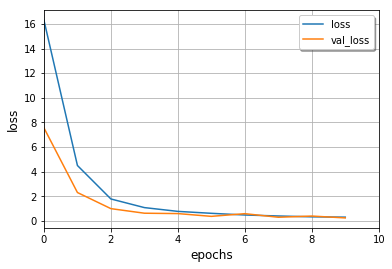

In [44]:
loss_histroy(base_shuffle_history, epochs)

In [ ]:
# Train the model with ordered data and YUV images
base_model = nvidia_model(img_height, img_width, img_channels)

# early_stop = EarlyStopping(monitor='val_loss', patience=2)
base_YUV_history = base_model.fit(imgs_data_yuv, wheels_data_yuv, epochs=epochs, batch_size=batch_size, 
                                  verbose=1, validation_split=0.2)

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))

### 自定义模型

In [8]:
img_height = 66
img_width = 200
img_channels = 3
epochs = 15
batch_size=64

In [28]:
# def custom_model(img_height, img_width, img_channels):
#     model = Sequential()
#     model.add(Lambda(lambda x: x/255.-0.5, input_shape=(img_height, img_width, img_channels)))
#     # Cov layers
#     model.add(Conv2D(24, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', name='re_conv1'))
#     model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool1'))
    
#     model.add(Conv2D(36, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', name='re_conv2'))
#     model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool2'))
    
#     model.add(Conv2D(48, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', name='re_conv3'))
#     model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool3'))
    
#     model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', name='re_conv4'))
#     model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool4'))
    
#     model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal', name='re_conv5'))
#     model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool5'))
     
#     # Fullyconnected layer
#     model.add(Flatten())
#     model.add(BatchNormalization(name='re_bn1'))
#     model.add(Dense(1164, activation='relu', kernel_initializer='he_normal', name='re_den1'))
#     model.add(Dropout(0.25))
    
#     model.add(Dense(100, activation='relu', kernel_initializer='he_normal', name='re_den2'))
#     model.add(Dropout(0.25))
    
#     model.add(Dense(50, activation='relu', kernel_initializer='he_normal', name='re_den3'))
#     model.add(Dropout(0.25))
    
#     model.add(Dense(10, activation='relu', kernel_initializer='he_normal', name='re_den4'))
#     model.add(Dropout(0.5))
    
#     model.add(Dense(1, kernel_initializer='he_normal'))
    
#     model.compile(loss='mse', optimizer='adadelta', metrics=['mse'])
#     # model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
#     return model

In [32]:

modify_model = custom_model(img_height, img_width, img_channels)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
modify_model_history = modify_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                  verbose=1, validation_data=(X_val, y_val),callbacks =[early_stop])

# Test the performance on test data
test_loss= modify_model.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/15
38880/38880 [==============================] - 53s 1ms/step - loss: 14.6098 - mean_squared_error: 14.6098 - val_loss: 6.7892 - val_mean_squared_error: 6.7892
Epoch 2/15
38880/38880 [==============================] - 52s 1ms/step - loss: 8.6792 - mean_squared_error: 8.6792 - val_loss: 5.1022 - val_mean_squared_error: 5.1022
Epoch 3/15
38880/38880 [==============================] - 52s 1ms/step - loss: 7.2872 - mean_squared_error: 7.2872 - val_loss: 3.6612 - val_mean_squared_error: 3.6612
Epoch 4/15
38880/38880 [==============================] - 52s 1ms/step - loss: 6.5897 - mean_squared_error: 6.5897 - val_loss: 3.4952 - val_mean_squared_error: 3.4952
Epoch 5/15
38880/38880 [==============================] - 52s 1ms/step - loss: 6.3804 - mean_squared_error: 6.3804 - val_loss: 3.3169 - val_mean_squared_error: 3.3169
Epoch 6/15
38880/38880 [==============================] - 52s 1ms/step - loss: 6.0297 - mean_squared_error: 6.0297

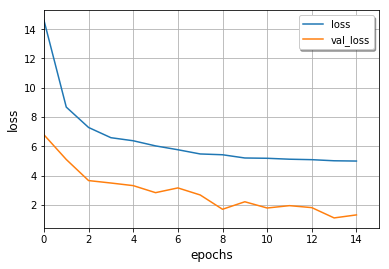

In [33]:
loss_histroy(modify_model_history, epochs)

In [34]:
model_saved_path = os.path.join(model_dir, "model.h5")
json_saved_path = os.path.join(model_dir, "model.json")

# save json
json_model = modify_model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
    
# save model
modify_model.save(model_saved_path)

In [35]:
machine_steering = modify_model.predict(imgs_test, batch_size=128, verbose=0)

In [36]:
def get_human_steering(epoch_id):
    steering_path = os.path.join(epoch_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    rows = pd.read_csv(steering_path)
    human_steering = list(rows.wheel.values)
    return human_steering

In [37]:
human_steering = get_human_steering(10)

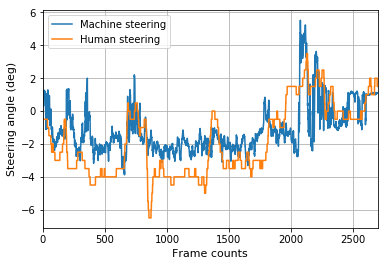

In [38]:
plt.figure
plt.plot(machine_steering)
plt.plot(human_steering)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Machine steering', 'Human steering'], loc='best')
plt.xlim((0,2700))
plt.grid()
plt.show()

In [39]:
human_steering = np.array(human_steering)
human_steering = np.reshape(human_steering,(len(human_steering),1))

In [41]:
angle_error = np.subtract(machine_steering, human_steering)

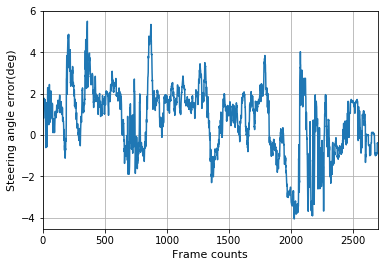

In [42]:
plt.figure
plt.plot(angle_error)
plt.ylabel('Steering angle error(deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.xlim((0,2700))
plt.grid()
plt.show()

In [9]:
# shuffle data
modify_model = custom_model(img_height, img_width, img_channels)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
modify_model_history = modify_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                                        validation_data=(X_val, y_val),callbacks =[early_stop], shuffle=True)

# Test the performance on test data
test_loss= modify_model.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/15
38880/38880 [==============================] - 55s 1ms/step - loss: 13.6126 - mean_squared_error: 13.6126 - val_loss: 11.8612 - val_mean_squared_error: 11.8612
Epoch 2/15
38880/38880 [==============================] - 53s 1ms/step - loss: 8.1887 - mean_squared_error: 8.1887 - val_loss: 6.1489 - val_mean_squared_error: 6.1489
Epoch 3/15
38880/38880 [==============================] - 53s 1ms/step - loss: 6.8705 - mean_squared_error: 6.8705 - val_loss: 3.1896 - val_mean_squared_error: 3.1896
Epoch 4/15
38880/38880 [==============================] - 53s 1ms/step - loss: 6.3669 - mean_squared_error: 6.3669 - val_loss: 2.7257 - val_mean_squared_error: 2.7257
Epoch 5/15
38880/38880 [==============================] - 53s 1ms/step - loss: 5.7726 - mean_squared_error: 5.7726 - val_loss: 2.5946 - val_mean_squared_error: 2.5946
Epoch 6/15
38880/38880 [==============================] - 53s 1ms/step - loss: 5.8335 - mean_squared_error: 5.83

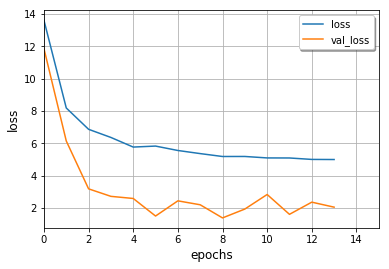

In [10]:
loss_histroy(modify_model_history, epochs)

In [15]:
tuning_mode,tuning_mode_history = fine_tuning(modify_model, X_train, y_train, X_val, y_val, 10)

Train on 38880 samples, validate on 9720 samples
Epoch 1/2
38880/38880 [==============================] - 22s 567us/step - loss: 5.1092 - mean_squared_error: 5.1092 - val_loss: 1.6220 - val_mean_squared_error: 1.6220
Epoch 2/2
38880/38880 [==============================] - 22s 564us/step - loss: 4.9873 - mean_squared_error: 4.9873 - val_loss: 1.6714 - val_mean_squared_error: 1.6714


In [21]:
log_file = 'finetune-9-0.9494.h5'
tuning_mode,tuning_mode_history = fine_tuning(modify_model, X_train, y_train, X_val, y_val, 9, epochs=5, weights=log_file)

Train on 38880 samples, validate on 9720 samples
Epoch 1/5
38880/38880 [==============================] - 24s 614us/step - loss: 4.8503 - mean_squared_error: 4.8503 - val_loss: 1.5618 - val_mean_squared_error: 1.5618
Epoch 2/5
38880/38880 [==============================] - 23s 595us/step - loss: 4.8742 - mean_squared_error: 4.8742 - val_loss: 1.2195 - val_mean_squared_error: 1.2195
Epoch 3/5
38880/38880 [==============================] - 23s 596us/step - loss: 4.7416 - mean_squared_error: 4.7416 - val_loss: 1.7182 - val_mean_squared_error: 1.7182
Epoch 4/5
38880/38880 [==============================] - 23s 600us/step - loss: 4.6454 - mean_squared_error: 4.6454 - val_loss: 1.8937 - val_mean_squared_error: 1.8937


In [23]:
# Test the performance on test data
test_loss= tuning_mode.evaluate(imgs_test, wheels_test, batch_size=batch_size)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 1s 430us/step
Test loss is:[5.066381001869837, 5.066381001869837]
